In [67]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrd

import optax
import time as tm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from jax import jit, vmap
from tqdm.notebook import tqdm

In [68]:
tf.config.set_visible_devices([], "GPU")

In [69]:
@jit
def attention_block(x, params):
    """
    x.shape = (B, L, d_model)
    W_Q.shape = (d_model, d_QK)
    W_K.shape = (d_model, d_QK)
    W_V.shape = (d_model, d_V)
    """
    
    W_Q, W_K, W_V = params
    
    Q = x @ W_Q
    K = x @ W_K
    V = x @ W_V

    A = Q @ jnp.swapaxes(K, -1, -2)
    A = A / jnp.sqrt(Q.shape[-1])
    A = softmax(A)
    
    y = A @ V
    return y


@jit
def linear(x, params):
    """
    x.shape = (B, L, d_in)
    W.shape = (d_in, d_out)
    b.shape = (d_out,)
    """
    
    W, b = params
    return x @ W + b


@jit
def layer_norm(x, params):
    gamma, beta = params
    mean = jnp.mean(x, axis=-1, keepdims=True)
    var = jnp.mean((x - mean) ** 2, axis=-1, keepdims=True)
    x_hat = (x - mean) / jnp.sqrt(var + 1e-6)
    y = gamma * x_hat + beta
    return y


@jit
def dropout(x, p, subkey):
    mask = jrd.uniform(subkey, shape=x.shape)
    mask = (mask > p).astype(jnp.int32)
    return x * mask / (1 - p)


@jit
def softmax(x, axis=-1):
    e_x = jnp.exp(x - jnp.max(x, axis=axis, keepdims=True))
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


@jit
def relu(x):
    return jnp.maximum(0, x)


@jit
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


@jit
def sum_pool(x):
    return jnp.sum(x, axis=-2)


@jit
def mean_pool(x):
    return jnp.mean(x, axis=-2)

In [70]:
structure = [
    ("linear", (16, 64)),
    ("positional_embedding", (49, 64)),
    ("layer_norm", (64,)),
    
    ("collect_residual", ()),
    ("attention", (64, 64, 64)),
    ("add_residual", ()),
    ("layer_norm", (64,)),
    
    ("collect_residual", ()),
    ("linear", (64, 128)),
    ("relu", ()),
    ("linear", (128, 64)),
    ("add_residual", ()),
    ("layer_norm", (64,)),
    
    ("collect_residual", ()),
    ("attention", (64, 64, 64)),
    ("add_residual", ()),
    ("layer_norm", (64,)),
    
    ("collect_residual", ()),
    ("linear", (64, 128)),
    ("relu", ()),
    ("linear", (128, 64)),
    ("add_residual", ()),
    ("layer_norm", (64,)),
    
    ("mean_pool", ()),
    ("linear", (64, 10)),
]

In [71]:
key = jrd.PRNGKey(0)
params = []

for layer, shape in structure:
    if layer == "attention":
        print(layer)
        key, k1, k2, k3 = jrd.split(key, 4)
        d_model, d_QK, d_V = shape
        params.append([
            jrd.normal(k1, shape=(d_model, d_QK)) * 0.02,
            jrd.normal(k2, shape=(d_model, d_QK)) * 0.02,
            jrd.normal(k3, shape=(d_model, d_V)) * 0.02,
        ])
    
    elif layer == "linear":
        print(layer)
        key, subkey = jrd.split(key)
        # shape.shape = d_in, d_out
        params.append([
            jrd.normal(subkey, shape=shape) * 0.01,
            jnp.zeros(shape=(shape[1],))
        ])

    elif layer == "layer_norm":
        print(layer)
        params.append([
            jnp.ones(shape),
            jnp.zeros(shape),
        ])

    elif layer == "positional_embedding":
        print(layer)
        key, subkey = jrd.split(key)
        # shape.shape = (num_tokens, token_length)
        params.append(0.02 * jrd.normal(subkey, shape=shape))

    else:
        print(layer, "(no params)")
        params.append([])

linear
positional_embedding
layer_norm
collect_residual (no params)
attention
add_residual (no params)
layer_norm
collect_residual (no params)
linear
relu (no params)
linear
add_residual (no params)
layer_norm
collect_residual (no params)
attention
add_residual (no params)
layer_norm
collect_residual (no params)
linear
relu (no params)
linear
add_residual (no params)
layer_norm
mean_pool (no params)
linear


In [72]:
@jit
def forward(x, params):
    for i in range(len(structure)):
        layer = structure[i][0]
        if layer == "attention":
            x = attention_block(x, params[i])
        elif layer == "linear":
            x = linear(x, params[i])
        elif layer == "layer_norm":
            x = layer_norm(x, params[i])
        elif layer == "relu":
            x = relu(x)
        elif layer == "sigmoid":
            x = sigmoid(x)
        elif layer == "softmax":
            x = softmax(x)
        elif layer == "sum_pool":
            x = sum_pool(x)
        elif layer == "mean_pool":
            x = mean_pool(x)
        elif layer == "collect_residual":
            residual = x
        elif layer == "add_residual":
            x = x + residual
        elif layer == "positional_embedding":
            x = x + params[i]
        else:
            raise Exception("Unidentified layer " + layer)

    return x

In [73]:
batch_size = 256
patch_size_dim = 4
num_patches_per_dim = 28 // patch_size_dim  # 7
num_patches = num_patches_per_dim ** 2  # 49
patch_size = patch_size_dim * patch_size_dim  # 16

train_ds, test_ds = tfds.load(
    "fashion_mnist",
    split=["train", "test"],
    as_supervised=True,
)

def augment(img, lbl):
    img = tf.cast(img, tf.float32)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize_with_crop_or_pad(img, 32, 32)
    img = tf.image.random_crop(img, size=[28, 28, 1])
    return img, lbl

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(60000) 
test_ds  = test_ds.batch(10000)

raw_train_x, raw_train_y = next(iter(tfds.as_numpy(train_ds)))
raw_test_x, raw_test_y   = next(iter(tfds.as_numpy(test_ds)))

train_x = jnp.array(raw_train_x, dtype=jnp.float32) / 255.0
train_y = jnp.array(raw_train_y, dtype=jnp.int32)

test_x = jnp.array(raw_test_x, dtype=jnp.float32) / 255.0
test_y = jnp.array(raw_test_y, dtype=jnp.int32)

def images_to_patches(x):
    x = x.reshape(
        x.shape[0], 
        num_patches_per_dim, 
        patch_size_dim, 
        num_patches_per_dim, 
        patch_size_dim
    )
    x = x.transpose(0, 1, 3, 2, 4)
    x = x.reshape(x.shape[0], num_patches, patch_size)
    return x

num_train_batches = train_x.shape[0] // batch_size
num_test_batches = test_x.shape[0] // batch_size

train_x = train_x[:num_train_batches * batch_size]
train_y = train_y[:num_train_batches * batch_size]
test_x = test_x[:num_test_batches * batch_size]
test_y = test_y[:num_test_batches * batch_size]

train_x = images_to_patches(train_x).reshape(num_train_batches, batch_size, num_patches, patch_size)
train_y = train_y.reshape(num_train_batches, batch_size)

test_x = images_to_patches(test_x).reshape(num_test_batches, batch_size, num_patches, patch_size)
test_y = test_y.reshape(num_test_batches, batch_size)

# (num_batches, batch_size, num_patches, patch_size)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(234, 256, 49, 16) (234, 256)
(39, 256, 49, 16) (39, 256)


In [74]:
@jit
def cross_entropy_loss(x, y, params):
    logits = forward(x, params)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, y)
    return jnp.mean(loss)

cross_entropy_loss_value_and_grad = jax.value_and_grad(cross_entropy_loss, argnums=2)

In [75]:
@jit
def train_step(carry, ds):
    params, opt_state = carry
    loss, grads = cross_entropy_loss_value_and_grad(*ds, params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return (params, opt_state), loss

In [76]:
@jit
def calc_accuracy(x, y, params):
    logits = forward(x, params)
    x_hat = jnp.argmax(logits, axis=1)
    return jnp.sum(y == x_hat) / x_hat.shape[0]

In [78]:
epochs = 100

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=10*len(train_x),
    decay_steps=len(train_x)*epochs,
    end_value=1e-5
)

optimizer = optax.adamw(
    learning_rate = schedule,
    weight_decay = 0.05,
)

opt_state = optimizer.init(params)

total_train_losses = np.empty(shape=(epochs, train_x.shape[0]))
total_test_losses = np.empty(shape=(epochs, test_x.shape[0]))
total_train_accuracy = np.empty(shape=(epochs, train_x.shape[0]))
total_test_accuracy = np.empty(shape=(epochs, test_x.shape[0]))

for i in tqdm(range(epochs)):
    (params, opt_state), total_train_losses[i] = lax.scan(
        train_step, 
        (params, opt_state),
        (train_x, train_y),
    )
    
    total_test_losses[i] = np.array([
        cross_entropy_loss(test_x[j], test_y[j], params)
        for j in range(test_x.shape[0])
    ])

    total_train_accuracy[i] = np.array([
        calc_accuracy(train_x[j], train_y[j], params)
        for j in range(train_x.shape[0])
    ])

    total_test_accuracy[i] = np.array([
        calc_accuracy(test_x[j], test_y[j], params)
        for j in range(test_x.shape[0])
    ])

  0%|          | 0/100 [00:00<?, ?it/s]

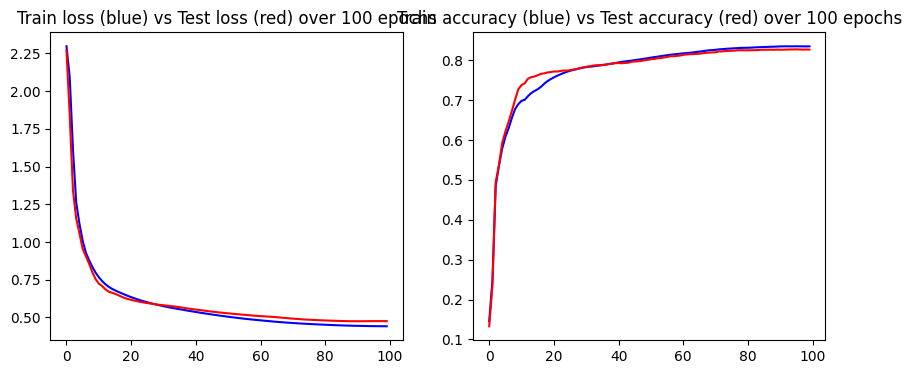

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].set_title(f"Train loss (blue) vs Test loss (red) over {epochs} epochs")
axs[0].plot(np.mean(total_train_losses, axis=1), color='blue')
axs[0].plot(np.mean(total_test_losses, axis=1), color='red')

axs[1].set_title(f"Train accuracy (blue) vs Test accuracy (red) over {epochs} epochs")
axs[1].plot(np.mean(total_train_accuracy, axis=1), color='blue')
axs[1].plot(np.mean(total_test_accuracy, axis=1), color='red')

plt.show()